In [1]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,MaxPooling2D,Conv2D, BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.random import shuffle
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks

#### importing librariess for emojis

In [2]:
import tkinter as tk
from tkinter import *
from PIL import Image, ImageTk
import os
import threading
from tqdm import tqdm
import matplotlib.pyplot as plt
from tkinter import LEFT, RIGHT, BOTTOM, Button

Target size is nothing but the size of image i.e 48 by 48 pixels
Batch size is the no of training examples in an iteration

In [26]:
classes = {'angry':0,'disgust':1,'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6}

IMAGE_WIDTH=48
IMAGE_HEIGHT=48
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
BATCH_SIZE=28
N_CLASSES = 7
EPOCHS = 20

TRAIN_ANGRY_DIR='data/train/angry'
TRAIN_DISGUST_DIR='data/train/disgust'
TRAIN_FEAR_DIR='data/train/fear'
TRAIN_HAPPY_DIR='data/train/happy'
TRAIN_NEUTRAL_DIR='data/train/neutral'
TRAIN_SAD_DIR='data/train/sad'
TRAIN_SURPRISE_DIR='data/train/surprise'

def assign_label(img,mood_type):
    return mood_type

X = []
y = []

def make_data(mood_type,DIR,X=X,y=y):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,mood_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (IMAGE_WIDTH,IMAGE_HEIGHT))
        
        X.append(np.array(img))
        y.append(str(label))

In [28]:
make_data(classes.get('angry'), TRAIN_ANGRY_DIR)
make_data(classes.get('disgust'), TRAIN_DISGUST_DIR)
make_data(classes.get('fear'), TRAIN_FEAR_DIR)
make_data(classes.get('happy'), TRAIN_HAPPY_DIR)
make_data(classes.get('neutral'), TRAIN_NEUTRAL_DIR)
make_data(classes.get('sad'), TRAIN_SAD_DIR)
make_data(classes.get('surprise'), TRAIN_SURPRISE_DIR)

100%|██████████| 3171/3171 [00:01<00:00, 3085.96it/s]


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

In [30]:
y_train = np.array(y_train)
y_test = np.array(y_test)
X_train = np.array(X_train)
X_test = np.array(X_test)

In [31]:
X_train = X_train/255
X_test = X_test/255
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [32]:
y_train = to_categorical(y_train, num_classes=N_CLASSES)
y_test = to_categorical(y_test, num_classes=N_CLASSES)

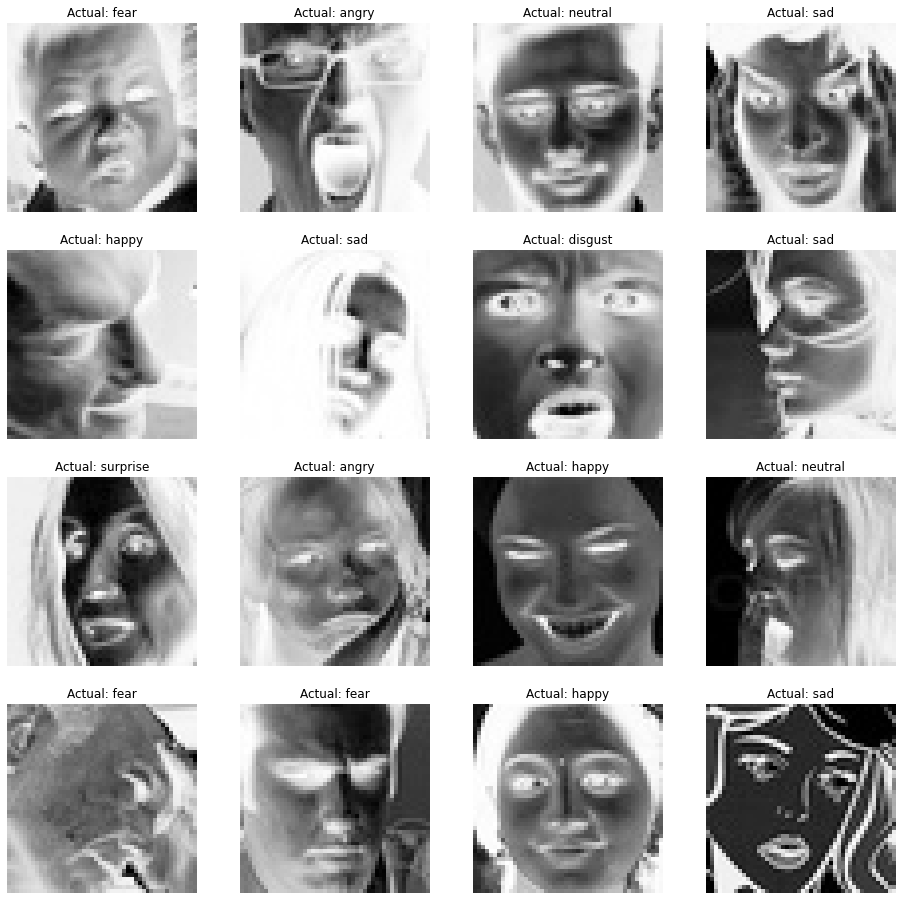

In [41]:
labels = '''angry
disgust
fear
happy
neutral
sad
surprise
'''.split("\n")

plt.figure(figsize=(16,16))
j = 1
for i in np.random.randint(0,2000,16):
    plt.subplot(4,4,j); j+=1
    plt.imshow(X_train[i],cmap = 'Greys')
    plt.axis('off')
    plt.title("Actual: {}".format(labels[np.argmax(y_train[i])]))
    #plt.title('{} / {}'.format(labels[y_train[i]],y_train[i]))


# Creating Model

In [34]:
emotions_model=Sequential()
emotions_model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(X_train[0].shape)))
emotions_model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
emotions_model.add(BatchNormalization())
emotions_model.add(MaxPooling2D(pool_size=(2,2)))
emotions_model.add(Dropout(0.25))
emotions_model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
emotions_model.add(BatchNormalization())
emotions_model.add(MaxPooling2D(pool_size=(2,2)))
emotions_model.add(Dropout(0.15))
emotions_model.add(Conv2D(256,kernel_size=(3,3),activation='relu'))
emotions_model.add(BatchNormalization())
emotions_model.add(MaxPooling2D(pool_size=(2,2)))
emotions_model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
emotions_model.add(BatchNormalization())
emotions_model.add(MaxPooling2D(pool_size=(2,2)))
emotions_model.add(Dropout(0.15))
emotions_model.add(Flatten())
emotions_model.add(Dense(512,activation='relu'))
emotions_model.add(Dropout(0.2))
emotions_model.add(Dense(256,activation='relu'))
emotions_model.add(Dropout(0.2))
emotions_model.add(Dense(7,activation='softmax'))

In [35]:
emotions_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 44, 44, 64)        18496     
_________________________________________________________________
batch_normalization_12 (Batc (None, 44, 44, 64)        256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 20, 20, 128)       73856     
_________________________________________________________________
batch_normalization_13 (Batc (None, 20, 20, 128)      

Using sequential model for better identification of objects(facial expressions) through using

Conv2D with input size of 32 and kernal kernelsize(height=3,width=3) in grayscale

MaxPooling2D that creates pool of size(h,w)=(2,2)

Dropout layer is used to reduce overfitting

Flattening layers to turn all those neurons 

Dense layers are the hidden layer containing the no of neurons i.e 1024 neurons while the last dense layers contains 7 neurons which should be same to the no of possibilities (i.e 7 classes)


## Training Model

In [36]:
emotions_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                              patience=3, min_lr=0.00001)

emotions_model_info= emotions_model.fit(X_train, y_train, epochs=EPOCHS, batch_size = BATCH_SIZE, validation_data= (X_test, y_test), callbacks=[reduce_lr])

emotions_model.save_weights('models.h5')

Epoch 1/20
821/821 [==============================] - 366s 445ms/step - loss: 1.6724 - accuracy: 0.3337 - val_loss: 1.6143 - val_accuracy: 0.3398
Epoch 2/20
821/821 [==============================] - 362s 441ms/step - loss: 1.3757 - accuracy: 0.4765 - val_loss: 1.3413 - val_accuracy: 0.4892
Epoch 3/20
821/821 [==============================] - 364s 444ms/step - loss: 1.2451 - accuracy: 0.5292 - val_loss: 1.3980 - val_accuracy: 0.4650
Epoch 4/20
821/821 [==============================] - 361s 440ms/step - loss: 1.1585 - accuracy: 0.5657 - val_loss: 1.4340 - val_accuracy: 0.4605
Epoch 5/20
821/821 [==============================] - 363s 442ms/step - loss: 1.0847 - accuracy: 0.5916 - val_loss: 1.1646 - val_accuracy: 0.5599
Epoch 6/20
821/821 [==============================] - 362s 441ms/step - loss: 1.0207 - accuracy: 0.6145 - val_loss: 1.1809 - val_accuracy: 0.5653
Epoch 7/20
821/821 [==============================] - 361s 440ms/step - loss: 0.9514 - accuracy: 0.6439 - val_loss: 1.1946 -

In [ ]:
emotions_model=Sequential()
emotions_model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(48,48,1)))
emotions_model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
emotions_model.add(MaxPooling2D(pool_size=(2,2)))
emotions_model.add(Dropout(0.25))
emotions_model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
emotions_model.add(MaxPooling2D(pool_size=(2,2)))
emotions_model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
emotions_model.add(MaxPooling2D(pool_size=(2,2)))
emotions_model.add(Dropout(0.25))
emotions_model.add(Flatten())
emotions_model.add(Dense(1024,activation='relu'))
emotions_model.add(Dropout(0.5))
emotions_model.add(Dense(7,activation='softmax'))
emotions_model.load_weights('models.h5')
cv2.ocl.setUseOpenCL(False)

### Emojis detection on training data

In [ ]:
emotion_dict= {0: "  Angry  ",1: "  Disgusted  ",2: "  Fearful  ",3: "  Happy  ", 4: "  Neutral  ", 5: "  Sad  " 
               , 6: "  Surprised  " }
file=os.path.abspath(__file__)
cur_path=os.path.dirname(file)

emoji_dict= {0:cur_path+'/emojis/Angry.png', 1:cur_path+'/emojis/Disgusted.png', 2:cur_path+'/emojis/Fearful.png', 3:cur_path+'/emojis/Happy.png',
            4: cur_path+'/emojis/Neutral.png', 5:cur_path+'/emojis/Sad.png', 6: cur_path+'/emojis/Surprise.png'}

global last_frame
last_frame=np.zeroes(480,640,3,dtype=uint8)
global cap1
show_text=[0]
global frame_number

In [ ]:
def show_subject():
    cap1=cv2.VideoCapture(0)
    if not cap1.isOpened():
        print("Can't open the Camera.")
    global frame_no
    length=int(cap1.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_no+=1
    if frame_no >= length:
        exit()
    cap1.set(1,frame_no)
    flag1,frame= cap1.read()
    frame1=cv2.resize(frame1,(600,500))
    bounding_box=cv2.CascadeClassifier("C:/Users/Hassan/anaconda3/Lib/site-packages/cv2/data/haarcascade_frontalface_default.xml")
    #converting image to grayscale for fast and better processing with required details.
    gray_frame=cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
    n_faces=BoundingBox.detectMultiScale(gray_frame,scale_factor=1.3,minNeighbors=5)
    
    
# after detecting faces from haar-cascade features, cropped images in final size as face detected w.r.t h,w,x and y axis.
    
    for (x,y,w,h )in n_faces:
        cv2,rectangle(frame1,(x,y-50),(x+w,y+h+10),(255,0,0),2)
        roi_gray_frame= gray_frame[y:y+h,x:x+w]
        crop_img=np.expand_dims(np.expand_dims(cv2.resize(roi_gray_frame, (48,48)),-1),0)
        
        #prediction
        predict=emotions_model.predict(crop_img)
        maxindex=int(np.argmax(predict))
        cv2.putText(frame1,emotion_dict[maxindex],(x+20,y-60),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2,cv2.LINE_AA)
        showText[0]=maxindex
    if flag1 is None:
        print("Major Error!")
    elif flag1:
        global last_frame1
        last_frame1= frame1.copy()
        pic=cv2.cvtColor(last_frame1,cv2.COLOR_BGR2RGB)
        img=Image.formarray(pic)
        imgtk=ImageTk.PhotoImage(image=img)
        lmain.imgtk=imgtk
        lmain.configure(image=imgtk)
        root.update()
        lmain.after(10,show_subject)
    if cv2.waitkey(1) &0xff ==ord('q'):
        exit()
            
        
    
    

### Show Avatar Function

In [ ]:
def show_avatar():
    frame2=cv2.imread(emojis_dist[show_text[0]])
    pic2=cv2.cvtColor(last_frame1,cv2.COLOR_BGR2RGB)
    img2=Image.fromarray(frame2)
    imgtk2=ImageTk.PhotoImage(image=img2)
    lmain.imgtk2=imgtk2
    lmain3.configure(text=emotion_dict[show_text[0]],font=('arial',45,bold))
    
    lmain2.configure(image=imgtk2)
    root.update()
    lmain2.after(10,show_avatar)

## Main function

In [ ]:
if __name__ == "__main__":
    frame_number=0
    root=tk.Tk()
    lmain=tk.Label(master=root,padx=50,bd=10)
    lmain2=tk.Label(master=root,bd=10)
    lmain3=tk.Label(master=root,bd=10,fg="#CDCDCD",bg="yellow")
    lmain.pack(side=LEFT)
    lmain.place(x=50,y=250)
    lmain3.pack()
    lmain3.place(x=600,y=250)
    #lmain3.place(x=960,y=250)
    lmain2.pack(side=RIGHT)
    lmain2.place(x=500,y=350)
    #lmain2.place(x=900,y=350)
    
    root_tile="Photo to Emoji"
    root.geometry("1400x900+100+10")
    root['bg']="blue"
    exitbtn= Button(root,text="Quit",fg="red",command=root.destroy,font=("arial",25,'bold')).pack(side=BOTTOM)
    threading.Thread(target=show_subject).start()
    threading.Thread(target=show_avatar).start()
    root.mainloop()